<a href="https://colab.research.google.com/github/ThoAus/learn-ligthning/blob/main/02_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Train a model (basic)
https://lightning.ai/docs/pytorch/stable/model/train_model_basic.html

In [2]:
# ! pip install lightning

In [3]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import lightning as L

import torch.utils.data as data
from torchvision import datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

### Dataset
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [4]:
# Load data sets
transform = transforms.ToTensor()
train_set = datasets.MNIST(root="data", download=True, train=True, transform=transform)
test_set = datasets.MNIST(root="data", download=True, train=False, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 105584013.07it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 56764617.54it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 31484814.56it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3680550.38it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
# Use 20% of training data for validation
train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size

# Split the training data into a training and validation set
seed = torch.Generator().manual_seed(42)
train_set, valid_set = data.random_split(train_set, [train_set_size, valid_set_size], generator=seed)

In [6]:
# Create the dataloader
batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

In [7]:
# Define function to show a batch of images
def show_batch(X, y):
    fig, axs = plt.subplots(1, 10, figsize=(10, 2))
    for i in range(10):
        axs[i].imshow(X[i].squeeze(), cmap="gray")
        axs[i].axis("off")

    for i, ax in enumerate(axs):
        ax.set_title(y[i].item())

    plt.show()

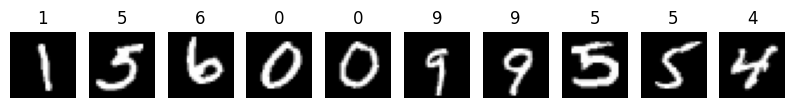

In [8]:
# Take a batch of data
X, y = next(iter(train_loader))

# Show a batch of images
show_batch(X, y)

### Modules and Model
https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

In [9]:
# Define the PyTorch nn.Modules
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(28 * 28, 64),
                                nn.ReLU(),
                                nn.Linear(64, 3))

    def forward(self, x):
        return self.l1(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(3, 64),
                                nn.ReLU(),
                                nn.Linear(64, 28 * 28))

    def forward(self, x):
        return self.l1(x)

In [10]:
class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        return loss

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        val_loss = F.mse_loss(x_hat, x)
        self.log("val_loss", val_loss)

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = F.mse_loss(x_hat, x)
        self.log("test_loss", test_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [11]:
# Create model
model = LitAutoEncoder(Encoder(), Decoder())

### Trainer
https://lightning.ai/docs/pytorch/stable/common/trainer.html

In [12]:
trainer = L.Trainer(max_epochs=5)
trainer.fit(model, train_loader, valid_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 50.4 K
1 | decoder | Decoder | 51.2 K
------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Typ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [13]:
# Test the model
trainer = L.Trainer()
trainer.test(model, dataloaders=DataLoader(test_set, batch_size=128))

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.039379820227622986    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.039379820227622986}]